This notebook contents are:

    (0) load model
    (1) image recognition
    (2) estimating RF(receptive field) by reverse correlation 
    (3) estimating RF by activation maximization
    (4) estimating prefered image by activation maximization (not only for first layer)
    (5) encoding and decoding experiment using Alexnet instead of a real brain
    (6) estimating tuning curve for orientation stimulus
    (7) decoding orientation using estimated tuning curve

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from scipy.misc import imresize
from scipy import interpolate
import pickle
import pandas as pd
import time
import os

import chainer
from chainer import Variable
import chainer.links as L
import chainer.functions as F
from chainer import serializers




In [2]:
data_dir = 'data'
model_dir = 'model'
fig_dir = 'fig'
temp_dir = 'temp'
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)
if not os.path.exists(temp_dir):
    os.mkdir(temp_dir)

In [3]:
class Alex(chainer.Chain):
    #structure of Alexnet
    def __init__(self):
        super(Alex, self).__init__(
            conv1=L.Convolution2D(None,  96, 11, stride=4),
            conv2=L.Convolution2D(None, 256,  5, pad=2),
            conv3=L.Convolution2D(None, 384,  3, pad=1),
            conv4=L.Convolution2D(None, 384,  3, pad=1),
            conv5=L.Convolution2D(None, 256,  3, pad=1),
            fc6=L.Linear(None, 4096),
            fc7=L.Linear(None, 4096),
            fc8=L.Linear(None, 1000)
        )
        self.dropout_rate = 0.1
    
        
    def __call__(self, x, layers):
        ret = {}
        en = layers[-1]
        h = self.conv1(x)
        if 'conv1' in layers:
            ret.update({'conv1':h})
            if en == 'conv1':
                return ret
        h = F.max_pooling_2d(F.local_response_normalization(
            F.relu(h)), 3, stride=2) 
        h = self.conv2(h)
        if 'conv2' in layers:
            ret.update({'conv2':h})
            if en == 'conv2':
                return ret
        h = F.dropout(h,ratio = self.dropout_rate)
        h = F.max_pooling_2d(F.local_response_normalization(
            F.relu(h)), 3, stride=2)
        h = self.conv3(h)
        if 'conv3' in layers:
            ret.update({'conv3':h})
            if en == 'conv3':
                return ret
        h = F.dropout(h,ratio = self.dropout_rate)
        h = F.relu(h)
        h = self.conv4(h)
        if 'conv4' in layers:
            ret.update({'conv4':h})
            if en == 'conv4':
                return ret
        h = F.dropout(h,ratio = self.dropout_rate)
        h = F.relu(h)
        h = self.conv5(h)
        if 'conv5' in layers:
            ret.update({'conv5':h})
            if en == 'conv5':
                return ret
        h = F.dropout(h,ratio = self.dropout_rate)
        h = F.max_pooling_2d(F.relu(h), 3, stride=2)
        h = self.fc6(h)
        if 'fc6' in layers:
            ret.update({'fc6':h})
            if en == 'fc6':
                return ret
        h = F.dropout(h,ratio = self.dropout_rate)
        h = F.relu(h)
        h = self.fc7(h)
        if 'fc7' in layers:
            ret.update({'fc7':h})
            if en == 'fc7':
                return ret
        h = F.dropout(h,ratio = self.dropout_rate)
        h = F.relu(h)
        h = self.fc8(h)
        if 'fc8' in layers:
            ret.update({'fc8':h})
        h = F.softmax(h)
        if 'prob' in layers:
            ret.update({'prob':h})
        return ret
    
    

# (0) load model

In [4]:
model = Alex()
serializers.load_hdf5('{}/Alex.h5'.format(model_dir),model)

# (1) image recognition

In [5]:
def prepare(img):
    #convert PIL Image to numpy array for chainer
    
    #to numpy array
    img = np.asarray(img)
    if not img.shape == (1,3,227,227):
        #resize image to the size used in Alexnet
        img = imresize(img,np.array([227,227]))
        #to BGR, which is used color order in Alexnet
        img = img[:,:,[2,1,0]]
        #reorder img to order used in chainer and convert dtype to np.float32 for chainer
        img = img.transpose(2,0,1).astype(np.float32)
        #add batch dimension for chainer
        img = np.expand_dims(img,axis=0)
    
    return img

def check_label(prediction):
    #ラベルを読み込む
    categories = np.loadtxt('{}/labels.txt'.format(data_dir), str, delimiter="\n")

    # スコアとラベルを紐づけスコアの高い順にソートする
    result = zip(prediction.data.reshape((prediction.data.size,)), categories)
    result = sorted(result, reverse=True)

    # 上位10個の結果を表示する
    for i, (score, label) in enumerate(result[:10]):
        print '{:>3d} {:>6.2f}% {}'.format(i + 1, score * 100, label)

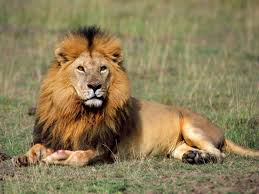

In [8]:
img = Image.open('{}/lion.png'.format(data_dir))
img

In [9]:
img = prepare(img)
prediction = model(img, layers = 'prob')['prob']
check_label(prediction)

  1  50.18% lion, king of beasts, Panthera leo
  2   5.91% chow, chow chow
  3   3.67% Pomeranian
  4   2.93% dhole, Cuon alpinus
  5   1.97% red fox, Vulpes vulpes
  6   1.73% Norwich terrier
  7   1.67% collie
  8   1.36% hyena, hyaena
  9   1.27% kit fox, Vulpes macrotis
 10   1.20% red wolf, maned wolf, Canis rufus, Canis niger


# (2) estimating RF by reverse correlation 

In [18]:
pos = np.array([14,14]) #where unit
ite = 1000

In [19]:
layer_name = 'conv1'

seed = 1
np.random.seed(seed)
img_inps = np.random.rand(ite,3,227,227).astype(np.float32) * 255
ua_list = []
#loop for collecting unit activations when random noise images are given
for k in range(ite):
    if np.mod(k,100)==0:
        print(k)
    img_inp = img_inps[k:k+1]
    feature = model(img_inp,layers=layer_name)[layer_name]
    unit_activation = feature[0,:,pos[0],pos[1]].data
    ua_list.append(unit_activation)

ua_list = np.array(ua_list)

0
100
200
300
400
500
600
700
800
900


In [20]:
np.save('{}/img_random_noise.npy'.format(temp_dir),img_inps)
np.save('{}/unit_act_random_noise.npy'.format(temp_dir),ua_list)

In [52]:
#estimate RF
#unit activation * input
rf_rc = np.tensordot(img_inps,ua_list,axes = [0,0]).transpose(3,1,2,0)/ite

In [53]:
def imshow(img,zoom = False,d=4,pos=pos):
    if zoom:
        plt.imshow(img[pos[0]*4-d:pos[0]*4 + 11 + d , pos[1]*4 - d : pos[1]*4 + 11 +d])
    else:
        plt.imshow(img)
    plt.axis('off')

def scaling(img):
    temp = img - np.min(img)
    temp = temp/np.max(temp)
    return temp

In [54]:
rf_rc_scaled = np.array([scaling(rf_rc[k]) for k in range(len(rf_rc))])

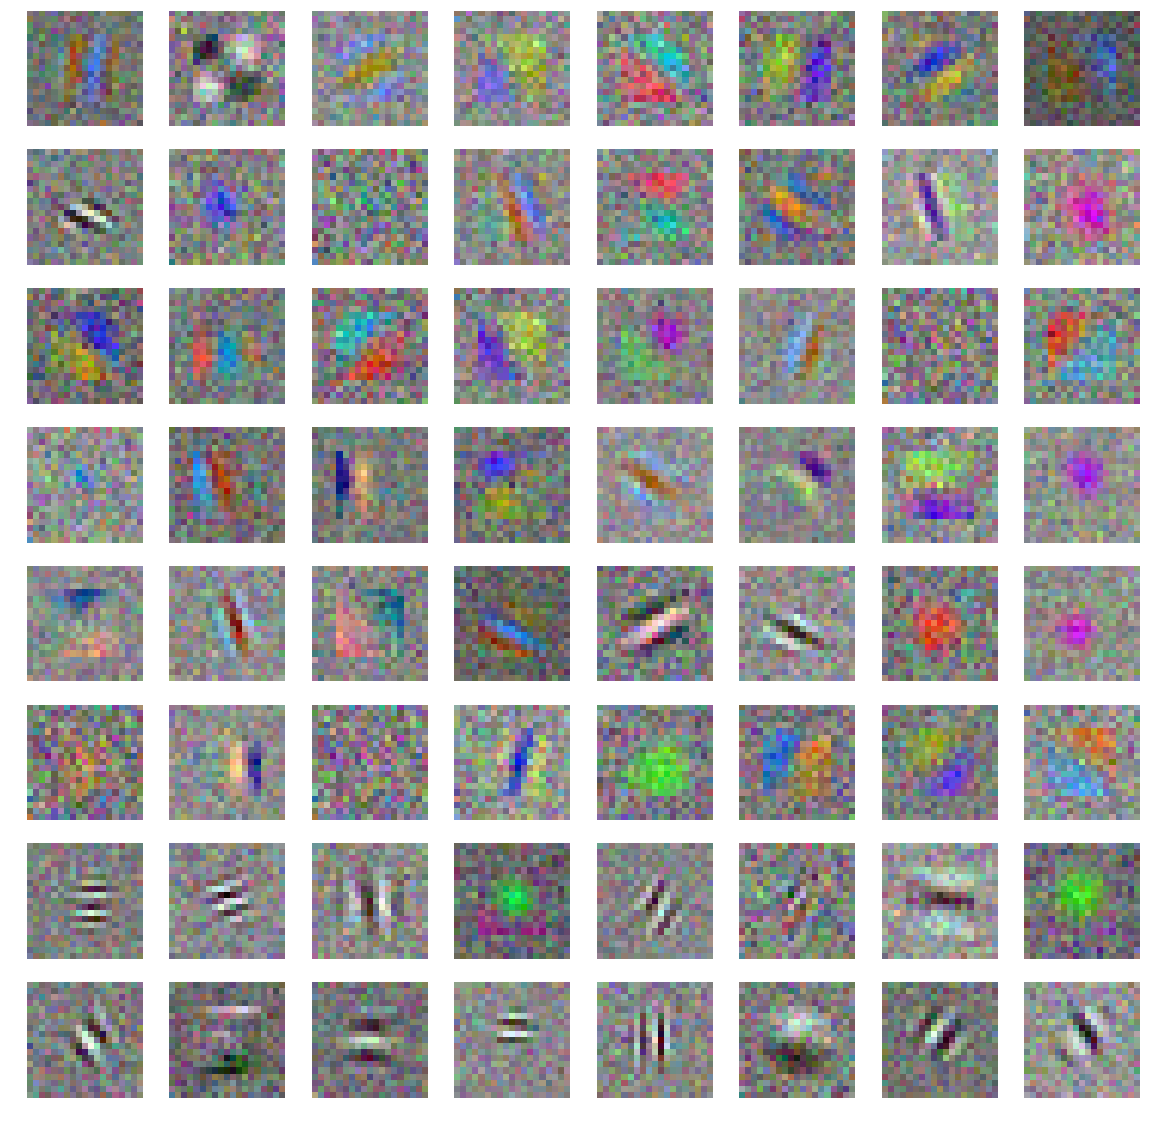

In [107]:
plt.figure(figsize=[20,20])
for ch in range(64):
    plt.subplot(8,8,ch+1)
    imshow(rf_rc_scaled[ch],zoom = True)
plt.savefig('{}/RF_rc'.format(fig_dir))

# (3) estimating RF by activation maximization

In [57]:
def am(layer_name,ch=0,pos=np.array([5,5]),lam =0.0001,lr = 1,ite=100,pri = False,show = False):
    #layer_name : layer name
    #ch : channel
    #pos : position of unit (only for conv unit)
    #lam : coefficient of regularization term
    #lr  : initial learning rate
    #ite : iteration of training
    
    img_inp = np.zeros([1,3,227,227]).astype(np.float32)
    img_reg = np.zeros([1,3,227,227]).astype(np.float32) + 128
    img_inp = Variable(img_inp)

    
    unit_act = -100
    for _ in range(ite):
#         if np.random.rand()<0.5:
#             img_inp.data = np.roll(img_inp.data,10,axis=2)
#         if np.random.rand()<0.5:
#             img_inp.data = np.roll(img_inp.data,10,axis=3)
        
        feature = model(img_inp,layers=[layer_name])[layer_name]
        if feature.data.ndim == 2:
            loss = -feature[0,ch] + lam * F.sum((img_inp - img_reg)**2)
        else:
            loss = -feature[0,ch,pos[0],pos[1]] + lam * F.sum((img_inp - img_reg)**2)

        img_inp.cleargrad()
        loss.backward()
        img_inp.data -= lr * img_inp.grad/np.mean(np.abs(img_inp.grad))
        
        grad_norm = np.sum(np.abs(img_inp.grad))
        if grad_norm < 0.0001:
            break
        if np.mod(_,10) == 0:
            if pri:
                print('----')
                print('iteration : {}'.format(_))
                print('grad norm : {}'.format(grad_norm))
            if feature.data.ndim == 2:
                if unit_act > feature[0,ch].data:
                    lr /= 2.0
                unit_act = feature[0,ch].data
                if pri:
                    print('unit act  : {}'.format(feature[0,ch].data))
            else:
                if unit_act > feature[0,ch,pos[0],pos[1]].data:
                    lr /= 2.0
                unit_act = feature[0,ch,pos[0],pos[1]].data           
                if pri:
                    print('unit act  : {}'.format(feature[0,ch,pos[0],pos[1]].data))
    
    if show:
        temp = img_inp.data[0].transpose(1,2,0)
        temp = (temp - temp.min())
        temp = temp/np.max(temp)
        plt.figure(figsize=[10,10])
        plt.imshow(temp)
        plt.axis('off')


    
    return img_inp


In [58]:
#AM for RF
out_ch_len = 15
in_ch_len = 1
zure = 0

#estimate RF by AM
rf_am_img = []
for k in range(out_ch_len):
    img_conv1 = am(layer_name = 'conv1',pos = pos, ch = zure + k,ite = 50,lr = 0.1 , lam = 0.0001)
    rf_am_img.append(img_conv1.data)

rf_am_imgs = np.vstack(rf_am_img)
rf_am_scaled = scaling(rf_am_imgs)
rf_am_scaled = rf_am_scaled.transpose(0,2,3,1)

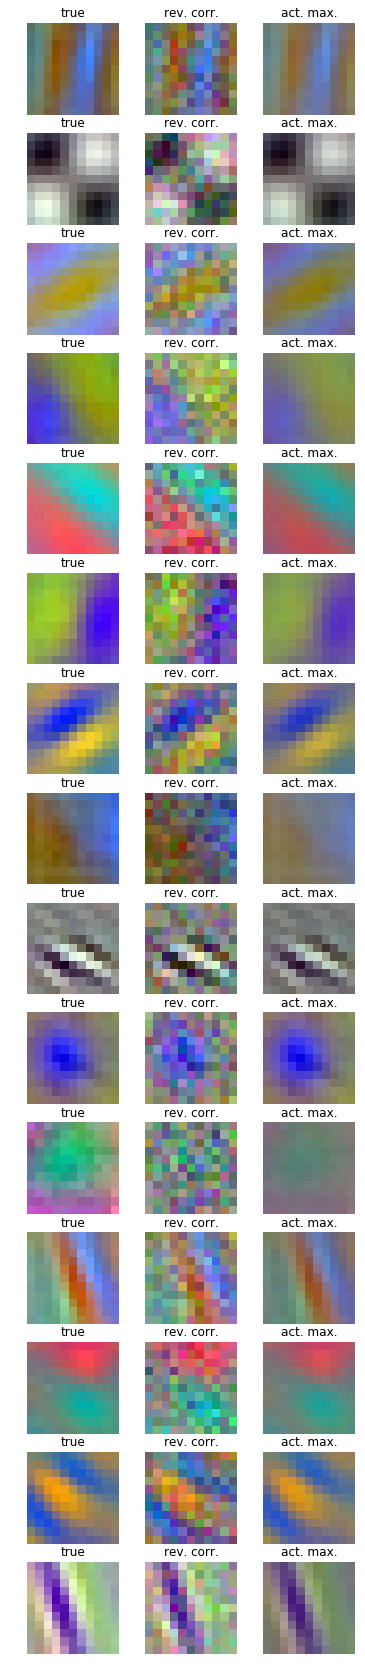

In [60]:
#plot
plt.figure(figsize=[6,2 * out_ch_len])
for out_ch in range(out_ch_len):
    for in_ch in range(in_ch_len):
        
        plt.subplot(out_ch_len,3,1 + 3*out_ch)
        true_weight = model.conv1.W.data[out_ch+zure].transpose(1,2,0)
        true_weight = scaling(true_weight)
        plt.imshow(true_weight)
        plt.axis('off')
        plt.title('true')
        plt.gray()
        
        plt.subplot(out_ch_len,3,2 + 3*out_ch)
        imshow(rf_rc_scaled[out_ch+zure,:,:],zoom=True,d=0)
        plt.title('rev. corr.')
        plt.gray()
        
        plt.subplot(out_ch_len,3,3 + 3*out_ch)
        imshow(rf_am_scaled[out_ch,:,:],zoom=True,d=0)
        plt.title('act. max.')
        plt.gray()
        

plt.savefig('{}/RF_rc_am.png'.format(fig_dir))

# (4) estimating prefered image by activation maximization (not only for first layer)

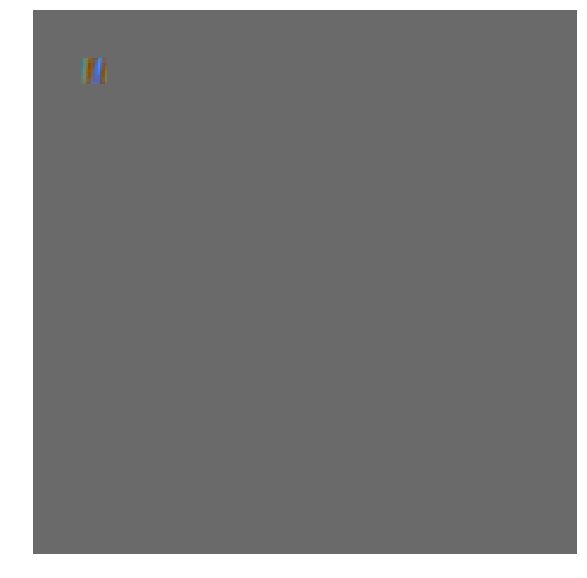

In [61]:
img_conv1 = am(layer_name = 'conv1', show = True)

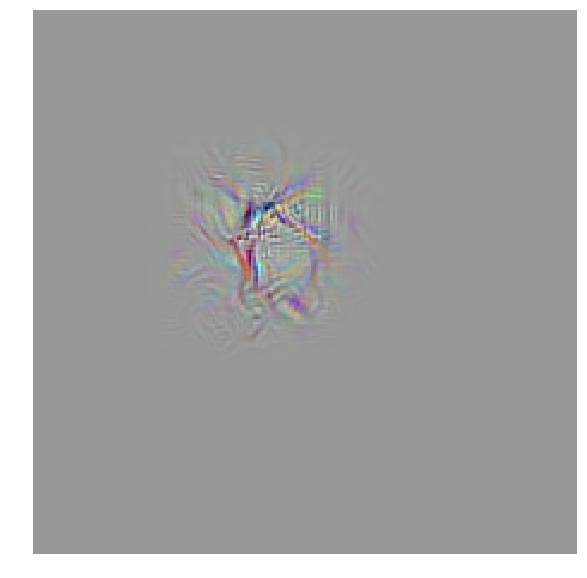

In [62]:
img_conv3= am(layer_name = 'conv3',ch=0, show = True)

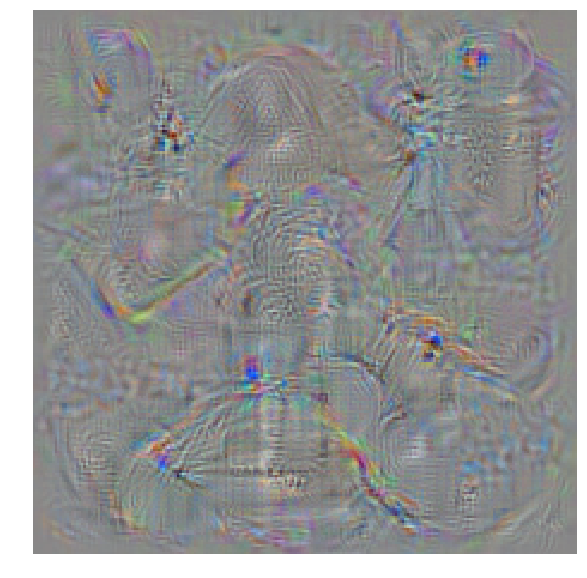

In [63]:
img_fc6 = am(layer_name = 'fc6',ch=4,ite=200, show = True,lam = 0.000001)

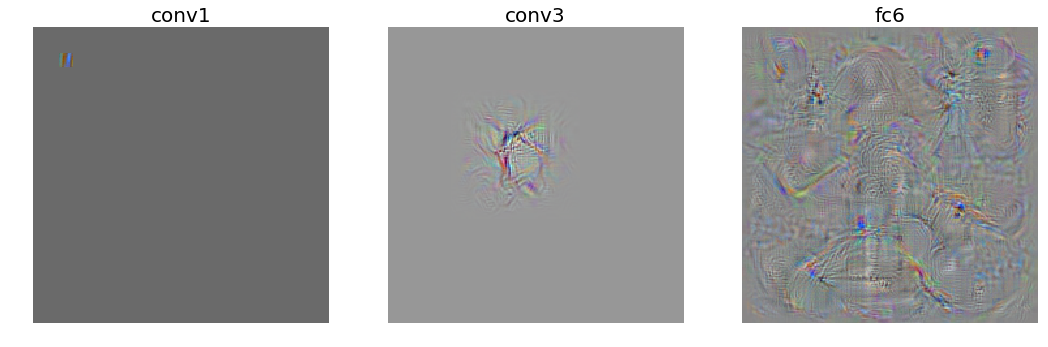

In [64]:
plt.figure(figsize = [18,6])
plt.subplot(1,3,1)
plt.imshow(scaling(img_conv1.data[0].transpose(1,2,0)))
plt.axis('off')
plt.title('conv1',fontsize = 20)
plt.subplot(1,3,2)
plt.imshow(scaling(img_conv3.data[0].transpose(1,2,0)))
plt.axis('off')
plt.title('conv3',fontsize = 20)
plt.subplot(1,3,3)
plt.imshow(scaling(img_fc6.data[0].transpose(1,2,0)))
plt.axis('off')
plt.title('fc6',fontsize = 20)
plt.title
plt.savefig('{}/activation_maximization'.format(fig_dir))

# (5) encoding and decoding experiment using Alexnet instead of a real brain

In [66]:
def collect_unit_act(model,img,label,n_unit,n_class,selected_unit_list):
    d = {}
    for ln in ln_list:
        d[ln] = []
    d['class'] = []

    for cl in range(n_class):
        d['class'].append(cl)
        feature = model(img[label == cl][:n_unit],layers=ln_list)
        for ln,su in zip(ln_list,selected_unit_list):
            temp = feature[ln][:].data
            d[ln].append(temp.reshape(len(temp),temp.size/len(temp))[:,su])
    return d


def log_gauss_p(x,m,sig):
    sig = sig + 1e-8
    return -0.5 * np.log(2 * np.pi) - np.log(sig) - (x-m)**2/2/sig**2

def inference(x,m_list,s_list,n_class):
    p = []
    for k in range(n_class):
        p.append(np.sum(log_gauss_p(x,m_list[k],s_list[k])))
    return np.argmax(p)




In [67]:
def encode_decode(data,n_unit,n_train,n_test,model):
    #prepare data
    #n_class = len(data['Category'])
    n_class = 4

    img_train = np.array(data['ImageTrain']).transpose(0,3,1,2).astype(np.float32)
    img_train = img_train[:,[2,1,0],:,:]
    label_train = np.array(data['LabelTrain'])
    img_test = np.array(data['ImageTest']).transpose(0,3,1,2).astype(np.float32)
    img_test = img_test[:,[2,1,0],:,:]
    label_test = np.array(data['LabelTest'])


    #initialize
    feature = model(img_train[0:1], layers=ln_list)
    n_unit_list = [len(feature[ln].data.flatten()) for ln in ln_list]
    selected_unit_list = [np.random.permutation(n_unit_ori)[:n_unit] for n_unit_ori in n_unit_list]

    # collect unit activity using training data
    print('collecting train data')
    d_train = collect_unit_act(model,img_train,label_train,n_train,n_class,selected_unit_list)

    # collect unit activity using testing data
    print('collecting test data')
    d_test = collect_unit_act(model,img_test,label_test,n_test,n_class,selected_unit_list)

    train = pd.DataFrame(d_train)
    test = pd.DataFrame(d_test)

    #最優推定
    #ユニットの活動はガウシアンであると仮定
    print('estimating')
    acc_list = []
    for ln in ln_list:
        #data preparation
        x_train = np.stack(train[ln].values)
        x_train = x_train.reshape(x_train.shape[0] * x_train.shape[1], x_train.shape[2])

        y_train = train['class'].values
        y_train = np.repeat(y_train,n_train)
        x_test = np.stack(test[ln].values)
        x_test = x_test.reshape(x_test.shape[0] * x_test.shape[1], x_test.shape[2])
        y_test = test['class'].values
        y_test = np.repeat(y_test,n_test)
        

        #train (estimate mean and std in each class)
        m_list = []
        s_list = []
        for k in range(n_class):
            temp = x_train[y_train == k]
            m = np.mean(temp,axis=0)
            s = np.std (temp,axis=0)
            m_list.append(m)
            s_list.append(s)
        #ML
        pred = []
        for k in range(len(x_test)):
            pred.append(inference(x_test[k,:],m_list,s_list,n_class))

        acc = np.mean(np.array(pred) == y_test)
        acc_list.append(acc)
    

#     plt.figure(figsize=[20,10])
#     plt.plot(acc_list)
#     plt.hlines(1.0/n_class,0,len(acc_list))
#     a = plt.xticks(np.arange(len(acc_list)),ln_list)
#     plt.ylabel('accuracy')
#     plt.xlabel('layer name')
    
    return acc_list

In [68]:
#load image data
with open('./data/Orientation.pickle','rb') as f:
    data_orientation = pickle.load(f)
with open('./data/ImageNet.pickle','rb') as f:
    data_image = pickle.load(f)
with open('./data/FMD.pickle','rb') as f:
    data_fmd = pickle.load(f)
    

In [69]:
#setting
ln_list = ['conv1','conv2','conv3','conv4','conv5','fc6','fc7','fc8']
n_unit=1000 #number of unit used in this analysis ( n < 1000)
model.dropout_rate = 0.5 
n_train = 40 #training data size (n < 40)
n_test = 10 #testing data size (n < 10)


In [ ]:
# perform encoding decoding analysis
print('orientation start')
acc_orientation = encode_decode(data_orientation,n_unit,n_train,n_test,model)
print('imagenet start')
acc_imagenet = encode_decode(data_image,n_unit,n_train,n_test,model)
print('FMD start')
acc_fmd = encode_decode(data_fmd,n_unit,n_train,n_test,model)

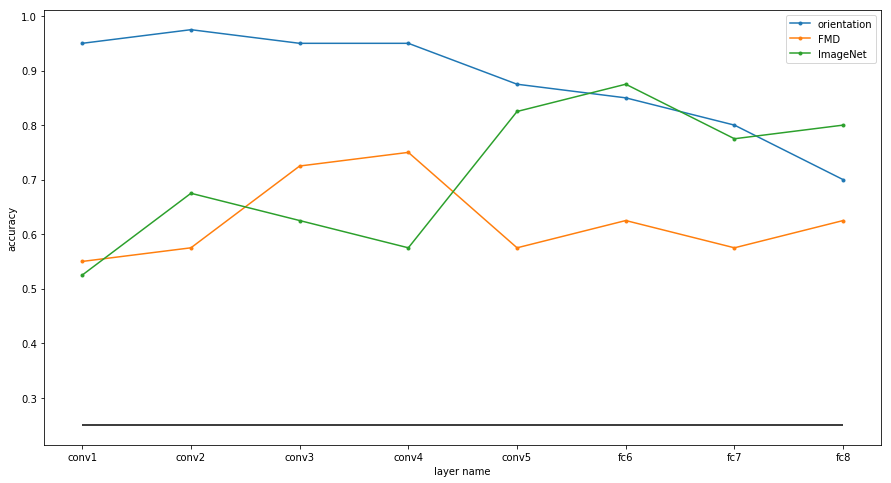

In [75]:
#plot
plt.figure(figsize=[15,8])
plt.plot(acc_orientation,'.-',label = 'orientation')
plt.plot(acc_fmd,'.-',label = 'FMD')
plt.plot(acc_imagenet,'.-',label = 'ImageNet')
plt.hlines(1.0/4,0,len(acc_fmd)-1)
a = plt.xticks(np.arange(len(acc_fmd)),ln_list)
plt.ylabel('accuracy')
plt.xlabel('layer name')
plt.legend()
plt.savefig('{}/enc_dec_acc'.format(fig_dir))

# (6) estimating tuning curve for orientation stimulus

In [76]:
def make_data(theta,omega,move=0,show = False):
    # make orientation image
    img = orientation_image(227, theta=theta,omega = omega,k = move)
    img = imresize(img,np.array([227,227]))
    if show == True:
        plt.imshow(img)
        plt.gray()
        plt.axis('off')
    img = np.repeat(np.expand_dims(img,axis=0),3,axis=0).astype(np.float32)


    return img

def pi_to_deg(x):
    return x/np.pi*180
    

def orientation_image(size,theta,omega,k = 0):
    # make orientation image
    x=np.arange(-size/2.0,size/2.0)
    y=np.arange(-size/2.0,size/2.0)

    xx=np.matlib.repmat(x,len(x),1)
    yy=np.matlib.repmat(y,len(y),1).T
    
    xy_rotation=xx*np.cos(theta + np.pi/2)+yy*np.sin(theta + np.pi/2)
    wave=np.cos(xy_rotation*omega+k)

    return(wave)

In [77]:
#show orientation image to the model
m_list = []
s_list = []

for k in range(33):
    img = make_data(np.pi /32 * k,0.01 * 65,show = False)
    img = np.expand_dims(img,axis=0)
    fea = F.relu(model(img,layers=['conv1'])['conv1'])[0].data
    m = [np.mean(f) for f in fea]
    s = [np.std(f) for f in fea]
    m_list.append(m)
    s_list.append(s)
    
s_list = np.array(s_list)
m_list = np.array(m_list)

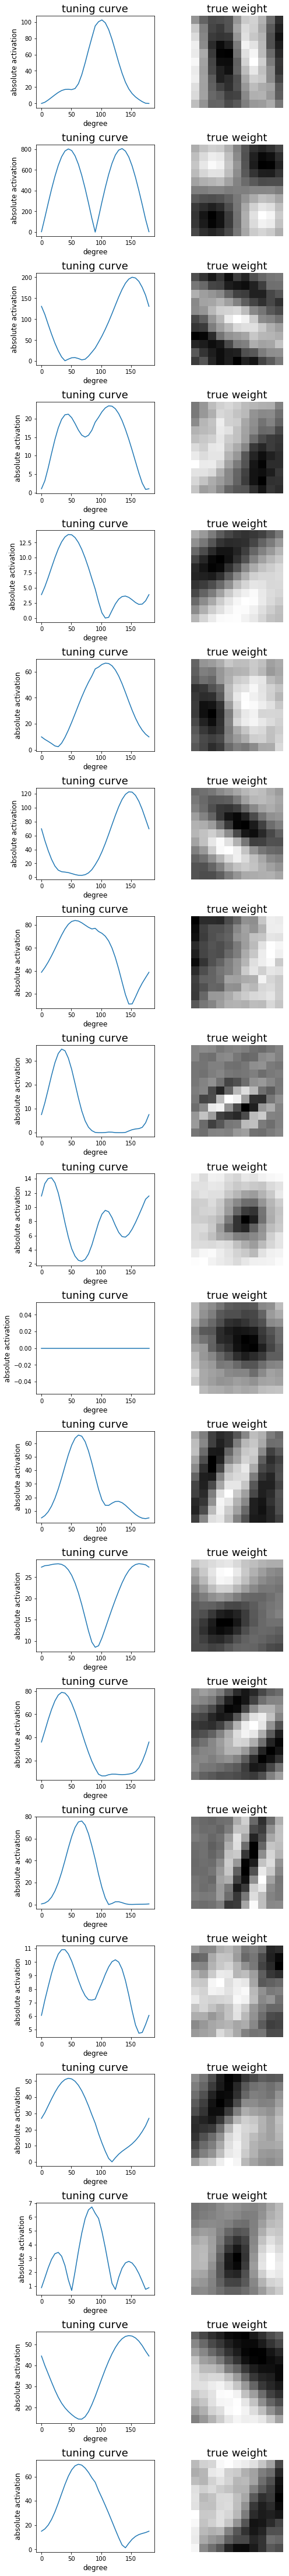

In [81]:
#plot
n_plot = 20
plt.figure(figsize=[4*2,4*n_plot])
for ch in range(n_plot):
    plt.subplot(n_plot,2,2*ch+1)

    temp_tuning = m_list[:,ch]
    temp_x = pi_to_deg(np.arange(33)/32.0 * np.pi)
    plt.plot(temp_x, temp_tuning)
    plt.ylabel('absolute activation',fontsize=12)
    plt.xlabel('degree',fontsize=12)
    plt.title('tuning curve',fontsize=18)

    plt.subplot(n_plot,2,2*ch+2)
    
    wei = np.mean(model.conv1.W[ch].transpose(1,2,0).data[:,::-1,0:1],axis=2)
    plt.imshow(wei)
    plt.axis('off')
    plt.title('true weight',fontsize = 18)
    
plt.subplots_adjust(hspace = 0.4)
plt.savefig('{}/tuning_curve_and_weight'.format(fig_dir))

# (7) decoding orientation using estimated tuning curve

In [105]:
theta_cand = np.linspace(0,np.pi,100)
ans_rec = []
for theta in theta_cand:
    img = make_data(theta,0.01 * 65,show = False)
    img = np.expand_dims(img,axis=0)
    fea = F.relu(model(img,layers=['conv1'])['conv1']).data[0]
    
    #それぞれのchからユニットを一つずつ取ってくる
    b = [np.random.choice(fea[k].flatten()) for k in range(len(fea))]
    b = np.array(b)

    #尤度
    log_p = 0
    for k in range(len(b)):
        if np.random.rand() < 0.5:#約半分のチャネル
            m_interpolated = interpolate.interp1d(np.arange(33) * np.pi / 32.0,m_list[:,k])
            s_interpolated = interpolate.interp1d(np.arange(33) * np.pi / 32.0,s_list[:,k])
            m = m_interpolated(theta_cand)
            s = s_interpolated(theta_cand)
            log_p += log_gauss_p(b[k],m,s)
    ans = theta_cand[np.argmax(log_p)]
    ans_rec.append(ans)

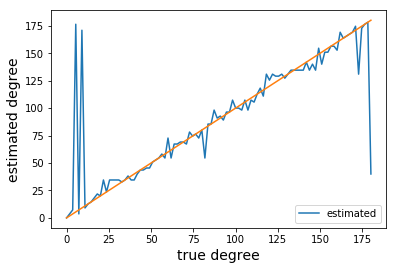

In [106]:
#plot
plt.plot(theta_cand/np.pi*180,np.array(ans_rec)/np.pi*180,label = 'estimated')
plt.plot(theta_cand/np.pi*180,theta_cand/np.pi*180)
plt.xlabel('true degree',fontsize = 14)
plt.ylabel('estimated degree',fontsize = 14)
plt.legend()
plt.savefig('{}/orientation_decoding'.format(fig_dir))